### read the data

In [1]:
import os
from os.path import join as pjoin
from tqdm import tqdm
import numpy as np
from io import BytesIO
import matplotlib.pyplot as plt 
from PIL import Image
import random
import matplotlib.cm as cm

In [2]:
colors = ['red', 'blue', 'black', 'red', 'blue',  
            'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue',
            'darkred', 'darkred','darkred','darkred','darkred']

In [3]:
def get_elev_azim_from_camera_matrix(camera_matrix):
    """Calculates elevation and azimuth angles from a camera matrix.

    Args:
        camera_matrix: A 4x4 numpy array representing the camera matrix.

    Returns:
        A tuple (elevation, azimuth) in radians.
    """
    rotation_matrix = camera_matrix[:3, :3]
    look_at_vector = rotation_matrix[2, :]  # Adjust index if using column-major convention

    # Normalize the look-at vector
    look_at_vector /= np.linalg.norm(look_at_vector)

    elevation = np.arcsin(look_at_vector[1])
    azimuth = np.arctan2(look_at_vector[0], look_at_vector[2])
    return elevation, azimuth

# Example usage
camera_matrix = np.array([
    [0.866, 0.0, -0.5, 0],
    [0.0, 1.0, 0.0, 0],
    [0.5, 0.0, 0.866, 0],
    [0.0, 0.0, 0.0, 1.0],
])

elev, azim = get_elev_azim_from_camera_matrix(camera_matrix)
print(f"Elevation: {np.rad2deg(elev):.2f} degrees")
print(f"Azimuth: {np.rad2deg(azim):.2f} degrees")

Elevation: 0.00 degrees
Azimuth: 30.00 degrees


In [42]:
###start of plot_3d_motion
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, PillowWriter
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import mpl_toolkits.mplot3d.axes3d as p3
def plot_3d_motion(joints,title = '', radius=4, plotName = 'newplot.png'):
#     matplotlib.use('Agg')

    max_len = joints.shape[0]
    target_frame = int(max_len//2)
    kinematic_tree = [[0, 2, 5, 8, 11], [0, 1, 4, 7, 10], [0, 3, 6, 9, 12, 15], [9, 14, 17, 19, 21], [9, 13, 16, 18, 20]]

    title_sp = title.split(' ')
    if len(title_sp) > 10:
        title = '\n'.join([' '.join(title_sp[:10]), ' '.join(title_sp[10:])])
    def init():
        ax.set_xlim3d([-radius / 2, radius / 2])
        ax.set_ylim3d([0, radius])
        ax.set_zlim3d([0, radius])
        # print(title)
        fig.suptitle(title, fontsize=20)
        ax.grid(b=False)

    def plot_xzPlane(minx, maxx, miny, minz, maxz):
        ## Plot a plane XZ
        verts = [
            [minx, miny, minz],
            [minx, miny, maxz],
            [maxx, miny, maxz],
            [maxx, miny, minz]
        ]
        xz_plane = Poly3DCollection([verts])
        xz_plane.set_facecolor((0.5, 0.5, 0.5, 0.5))
        ax.add_collection3d(xz_plane)

    #         return ax

    # (seq_len, joints_num, 3)
    data = joints.copy().reshape(len(joints), -1, 3)

    width_in_pixels = 480
    height_in_pixels = 480

    # Convert pixels to inches (1 inch = 2.54 cm)
    width_in_inches = width_in_pixels / plt.rcParams['figure.dpi']
    height_in_inches = height_in_pixels / plt.rcParams['figure.dpi']

    # Create the plot with the specified size
    # fig, ax = plt.subplots(figsize=(width_in_inches, height_in_inches))

    fig = plt.figure(figsize=(width_in_inches, height_in_inches))

    ax = p3.Axes3D(fig)
    init()
    MINS = data.min(axis=0).min(axis=0)
    MAXS = data.max(axis=0).max(axis=0)
    colors = ['green', 'pink', 'blue', 'yellow', 'red',  
              'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue',
             'darkred', 'darkred','darkred','darkred','darkred']
    


    # Set a seed value (e.g., 1234 for reproducibility)
    random.seed(232113)

    num_colors = len(colors)
    colors = [(random.random(), random.random(), random.random()) for _ in range(num_colors+10)]


    frame_number = data.shape[0]
    #     print(data.shape)

    height_offset = MINS[1]
    data[:, :, 1] -= height_offset
    trajec = data[:, 0, [0, 2]]
    
    # data[..., 0] -= data[:, 0:1, 0]
    # data[..., 2] -= data[:, 0:1, 2]

    #     print(trajec.shape)

    def update(index , trajectory_only = 'False'):
        #         print(index)
        # ax.lines.clear()
        ax.collections.clear()
        # ax.lines = []
        # ax.collections = []
        ax.view_init(elev=120, azim=-90)
        ax.dist = 7.5
        #         ax =

        # plot_xzPlane(MINS[0]
        #             #  -trajec[index, 0]
        #              , MAXS[0]
        #             #  -trajec[index, 0]
        #              ,0
        #              ,MINS[2]
        #             #    -trajec[index, 1]
        #                  ,MAXS[2]
        #                 #  -trajec[index, 1]
        #                  )


#         ax.scatter(data[index, :22, 0], data[index, :22, 1], data[index, :22, 2], color='black', s=3)
        if (trajectory_only == 'False'):
                
            trajec_color = 'blue'
            if trajectory_only == 'True':
                trajec_color = 'red'

            if index > 1:
                ax.plot3D(trajec[:index, 0]
                        #   -trajec[index, 0] ## these center the trajectory
                        , np.zeros_like(trajec[:index, 0]),
                            trajec[:index, 1]
                            # -trajec[index, 1] ## these center the trajectory
                            , linewidth=1.0,
                        color=trajec_color
                        )
            #             ax = plot_xzPlane(ax, MINS[0], MAXS[0], 0, MINS[2], MAXS[2])
            
        

        # cmap = cm.get_cmap('tab20')  # Choose a colormap
        # num_colors = 22  # Assuming kinematic_tree has a defined length

        cmap = cm.get_cmap('gist_ncar')
        num_colors = 26
        colors = cmap(np.linspace(0, 1, num_colors))
        for i, (chain, color) in enumerate(zip(kinematic_tree, colors)):
#             print(color)
            # print(chain)
            if i < 5:
                linewidth = 4.0
            else:
                linewidth = 2.0

            for j in range(len(chain) - 1):
                start_idx = chain[j]
                
                norm = start_idx / (num_colors - 1)
                color = cmap(norm)

                end_idx = chain[j + 1]
                # color = colors[start_idx]

                ax.plot3D(
                    [data[index, start_idx, 0], data[index, end_idx, 0]],
                    [data[index, start_idx, 1], data[index, end_idx, 1]],
                    [data[index, start_idx, 2], data[index, end_idx, 2]],
                    linewidth=linewidth,
                    color=colors[start_idx]
        )

        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
        ax.set_facecolor('black')
        
        # Set the color of the axes labels and ticks to white
        ax.w_xaxis.set_pane_color((0, 0, 0, 1))
        ax.w_yaxis.set_pane_color((0, 0, 0, 1))
        ax.w_zaxis.set_pane_color((0, 0, 0, 1))
        
        ax.xaxis._axinfo['grid'].update(color = 'w', linewidth = 0.5)
        ax.yaxis._axinfo['grid'].update(color = 'w', linewidth = 0.5)
        ax.zaxis._axinfo['grid'].update(color = 'w', linewidth = 0.5)
        
        ax.xaxis.label.set_color('white')
        ax.yaxis.label.set_color('white')
        ax.zaxis.label.set_color('white')
        
        ax.tick_params(axis='x', colors='white')
        ax.tick_params(axis='y', colors='white')
        ax.tick_params(axis='z', colors='white')
        
        fig.patch.set_facecolor('black')

    # ani = FuncAnimation(fig, update, frames=frame_number, interval=1000/fps, repeat=False)

    # ani.save(save_path, fps=fps)
    update(max_len-1,'True')
    update(target_frame,'True')
    update(0,'True')
    
    file_path = './conditions/' + plotName
    plt.show()
    plt.close()
    

    # return image


###end of plot_3d_motion

In [4]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, PillowWriter
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import mpl_toolkits.mplot3d.axes3d as p3
def plot_3d_motion(joints,radius=4, plotName = 'newplot.png'):
#     matplotlib.use('Agg')
    title = ''
    max_len = joints.shape[0]
    target_frame = int(max_len//2)
    kinematic_tree = [[0, 2, 5, 8, 11], [0, 1, 4, 7, 10], [0, 3, 6, 9, 12, 15], [9, 14, 17, 19, 21], [9, 13, 16, 18, 20]]
    title_sp = title.split(' ')
    if len(title_sp) > 10:
        title = '\n'.join([' '.join(title_sp[:10]), ' '.join(title_sp[10:])])
    def init():
        ax.set_xlim3d([-radius / 2, radius / 2])
        ax.set_ylim3d([0, radius])
        ax.set_zlim3d([0, radius])
        # print(title)
        fig.suptitle(title, fontsize=20)
        ax.grid(b=False)

    def plot_xzPlane(minx, maxx, miny, minz, maxz):
        ## Plot a plane XZ
        verts = [
            [minx, miny, minz],
            [minx, miny, maxz],
            [maxx, miny, maxz],
            [maxx, miny, minz]
        ]
        xz_plane = Poly3DCollection([verts])
        xz_plane.set_facecolor((0.5, 0.5, 0.5, 0.5))
        ax.add_collection3d(xz_plane)

    #         return ax

    # (seq_len, joints_num, 3)
    data = joints.copy().reshape(len(joints), -1, 3)

    width_in_pixels = 480
    height_in_pixels = 480

    # Convert pixels to inches (1 inch = 2.54 cm)
    width_in_inches = width_in_pixels / plt.rcParams['figure.dpi']
    height_in_inches = height_in_pixels / plt.rcParams['figure.dpi']

    # Create the plot with the specified size
    # fig, ax = plt.subplots(figsize=(width_in_inches, height_in_inches))

    fig = plt.figure(figsize=(width_in_inches, height_in_inches))

    ax = p3.Axes3D(fig)
    init()
    MINS = data.min(axis=0).min(axis=0)
    MAXS = data.max(axis=0).max(axis=0)
    colors = ['green', 'pink', 'blue', 'yellow', 'red',  
              'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue',
             'darkred', 'darkred','darkred','darkred','darkred']
    

    import random

    # Set a seed value (e.g., 1234 for reproducibility)
    random.seed(232113)

    num_colors = len(colors)
    colors = [(random.random(), random.random(), random.random()) for _ in range(num_colors+10)]


    frame_number = data.shape[0]
    #     print(data.shape)

    height_offset = MINS[1]
    data[:, :, 1] -= height_offset
    trajec = data[:, 0, [0, 2]]
    
    # data[..., 0] -= data[:, 0:1, 0]
    # data[..., 2] -= data[:, 0:1, 2]

    #     print(trajec.shape)

    def update(index , trajectory_only = 'False'):
        #         print(index)
        # ax.lines.clear()
        ax.collections.clear()
        # ax.lines = []
        # ax.collections = []
        ax.view_init(elev=120, azim=-90)
        ax.dist = 7.5
        #         ax =

        # plot_xzPlane(MINS[0]
        #             #  -trajec[index, 0]
        #              , MAXS[0]
        #             #  -trajec[index, 0]
        #              ,0
        #              ,MINS[2]
        #             #    -trajec[index, 1]
        #                  ,MAXS[2]
        #                 #  -trajec[index, 1]
        #                  )


#         ax.scatter(data[index, :22, 0], data[index, :22, 1], data[index, :22, 2], color='black', s=3)
        trajec_color = 'blue'
        if trajectory_only == 'True':
            trajec_color = 'red'

        if index > 1:
            ax.plot3D(trajec[:index, 0]
                    #   -trajec[index, 0] ## these center the trajectory
                      , np.zeros_like(trajec[:index, 0]),
                        trajec[:index, 1]
                        # -trajec[index, 1] ## these center the trajectory
                        , linewidth=1.0,
                      color=trajec_color
                      )
        #             ax = plot_xzPlane(ax, MINS[0], MAXS[0], 0, MINS[2], MAXS[2])
        
        import matplotlib.cm as cm

        # cmap = cm.get_cmap('tab20')  # Choose a colormap
        # num_colors = 22  # Assuming kinematic_tree has a defined length

        cmap = cm.get_cmap('gist_ncar')
        num_colors = 26
        colors = cmap(np.linspace(0, 1, num_colors))
        if (trajectory_only == 'False'):
            
            for i, (chain, color) in enumerate(zip(kinematic_tree, colors)):
    #             print(color)
                # print(chain)
                if i < 5:
                    linewidth = 4.0
                else:
                    linewidth = 2.0

                for j in range(len(chain) - 1):
                    start_idx = chain[j]
                    
                    norm = start_idx / (num_colors - 1)
                    color = cmap(norm)

                    end_idx = chain[j + 1]
                    # color = colors[start_idx]
                    ax.plot3D(
                        [data[index, start_idx, 0], data[index, end_idx, 0]],
                        [data[index, start_idx, 1], data[index, end_idx, 1]],
                        [data[index, start_idx, 2], data[index, end_idx, 2]],
                        linewidth=linewidth,
                        color=colors[start_idx]
            )

        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
        ax.set_facecolor('black')
        
        # Set the color of the axes labels and ticks to white
        ax.w_xaxis.set_pane_color((0, 0, 0, 1))
        ax.w_yaxis.set_pane_color((0, 0, 0, 1))
        ax.w_zaxis.set_pane_color((0, 0, 0, 1))
        
        ax.xaxis._axinfo['grid'].update(color = 'w', linewidth = 0.5)
        ax.yaxis._axinfo['grid'].update(color = 'w', linewidth = 0.5)
        ax.zaxis._axinfo['grid'].update(color = 'w', linewidth = 0.5)
        
        ax.xaxis.label.set_color('white')
        ax.yaxis.label.set_color('white')
        ax.zaxis.label.set_color('white')
        
        ax.tick_params(axis='x', colors='white')
        ax.tick_params(axis='y', colors='white')
        ax.tick_params(axis='z', colors='white')
        
        fig.patch.set_facecolor('black')

    # ani = FuncAnimation(fig, update, frames=frame_number, interval=1000/fps, repeat=False)

    # ani.save(save_path, fps=fps)
    update(max_len,'True')
    update(target_frame)
    
    file_path = './conditions/' + plotName

    # Save the plot as a PNG file
    # buf = BytesIO()
    plt.savefig(file_path)
    # plt.savefig(buf, format='png')
    # buf.seek(0)
    # image = plt.imread(buf)
    # plt.show()
    # plt.close()
    # return image
    return ''


In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, PillowWriter
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import mpl_toolkits.mplot3d.axes3d as p3
def plot_3d_motion(kinematic_tree, joints, title, figsize=(10, 10), fps=120, radius=4, index=2):
#     matplotlib.use('Agg')

    title_sp = title.split(' ')
    if len(title_sp) > 10:
        title = '\n'.join([' '.join(title_sp[:10]), ' '.join(title_sp[10:])])
    def init():
        ax.set_xlim3d([-radius / 2, radius / 2])
        ax.set_ylim3d([0, radius])
        ax.set_zlim3d([0, radius])
        # print(title)
        fig.suptitle(title, fontsize=20)
        ax.grid(b=False)

    def plot_xzPlane(minx, maxx, miny, minz, maxz):
        ## Plot a plane XZ
        verts = [
            [minx, miny, minz],
            [minx, miny, maxz],
            [maxx, miny, maxz],
            [maxx, miny, minz]
        ]
        xz_plane = Poly3DCollection([verts])
        xz_plane.set_facecolor((0.5, 0.5, 0.5, 0.5))
        ax.add_collection3d(xz_plane)

    #         return ax

    # (seq_len, joints_num, 3)
    data = joints.copy().reshape(len(joints), -1, 3)
    fig = plt.figure(figsize=figsize)
    ax = p3.Axes3D(fig)
    init()
    MINS = data.min(axis=0).min(axis=0)
    MAXS = data.max(axis=0).max(axis=0)
    colors = ['red', 'blue', 'black', 'red', 'blue',  
              'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue',
             'darkred', 'darkred','darkred','darkred','darkred']
    frame_number = data.shape[0]
    #     print(data.shape)

    height_offset = MINS[1]
    data[:, :, 1] -= height_offset
    trajec = data[:, 0, [0, 2]]
    
    # print(trajec)
    print("trajec", trajec.shape)

    data[..., 0] -= data[:, 0:1, 0]
    data[..., 2] -= data[:, 0:1, 2]
    
    # print("data", data)
    print("data", data.shape)

    #     print(trajec.shape)

    def update(index,ax):
        # print(index)
        ax.lines.clear()
        ax.collections.clear()
        # ax.lines = []
        # ax.collections = []
        ax.view_init(elev=120, azim=-90)
        ax.dist = 7.5
        ax = plot_xzPlane(MINS[0]-trajec[index, 0], MAXS[0]-trajec[index, 0], 0, MINS[2]-trajec[index, 1], MAXS[2]-trajec[index, 1])
        ax.scatter(data[index, :22, 0], data[index, :22, 1], data[index, :22, 2], color='black', s=3)
        
        if index > 1:
            ax.plot3D(trajec[:index, 0]-trajec[index, 0], np.zeros_like(trajec[:index, 0]), trajec[:index, 1]-trajec[index, 1], linewidth=1.0,
                      color='blue')
            # ax = plot_xzPlane(ax, MINS[0], MAXS[0], 0, MINS[2], MAXS[2])
        
        
        for i, (chain, color) in enumerate(zip(kinematic_tree, colors)):
#             print(color)
            if i < 5:
                linewidth = 4.0
            else:
                linewidth = 2.0
            ax.plot3D(data[index, chain, 0], data[index, chain, 1], data[index, chain, 2], linewidth=linewidth, color=color)
        #         print(trajec[:index, 0].shape)

        
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
        plt.show()


    # def update2(index):
    #     fig, ax = plt.subplots()
    #     data2 = map_into_camera(data)
        
    #     for index in range(len(data2)):

    #         ax.clear()
    #         # ... other plot settings ...

    #         for i, (chain, color) in enumerate(zip(kinematic_tree, colors)):
    #             if i < 5:
    #                 linewidth = 4.0
    #             else:
    #                 linewidth = 2.0

    #             # Plot only X and Y coordinates from original 3D data
    #             ax.plot(data2[index, chain, 0], data2[index, chain, 1], linewidth=linewidth, color=color)

    #             # Plot each joint as a point (optional)
    #             ax.scatter(data2[index, chain, 0], data2[index, chain, 1], marker='o', color='black') 

    #         # Adjust axis limits dynamically based on data
    #         # print(np.min(data2[index, :, 0]))
    #         # print(np.max(data2[index, :, 0]))
    #         # print(np.min(data2[index, :, 1]))
    #         # print(np.max(data2[index, :, 1]))
            
    #         ax.set_xlim([310, 330])
    #         ax.set_ylim([230, 250])
    #         ax.set_aspect('equal')
        
    #     plt.axis('off')
    #     ax.set_xticklabels([])
    #     ax.set_yticklabels([])
    #     # ax.set_zticklabels([])
    #     plt.show()

    update(index,ax)
    # update2(index)
    # ani = FuncAnimation(fig, update, frames=frame_number, interval=1000/fps, repeat=False)

    # ani.save(save_path, fps=fps)
    plt.close()


In [5]:
src_dir = './new_joints/'

In [6]:
kinematic_chain = [[0, 2, 5, 8, 11], [0, 1, 4, 7, 10], [0, 3, 6, 9, 12, 15], [9, 14, 17, 19, 21], [9, 13, 16, 18, 20]]

In [7]:
npy_files = os.listdir(src_dir)
npy_files = sorted(npy_files)
# npy_files = npy_files[:10]

In [8]:
npy_files[:10]

['000000.npy',
 '000001.npy',
 '000002.npy',
 '000003.npy',
 '000004.npy',
 '000005.npy',
 '000006.npy',
 '000007.npy',
 '000008.npy',
 '000009.npy']

In [9]:

directory_path = 'new_joints'  # replace with your directory path

# List all files in the directory and its subdirectories
files = []
for root, dirs, filenames in os.walk(directory_path):
    for filename in tqdm(filenames[:200]):
        try:
            path = os.path.join(root, filename)
            data = np.load(path)
            files.append(path)
            # max_len= int(data.shape[0])
            # target = int(data.shape[0] / 2)
            # plotName = filename.rsplit('.')[0] + '.png'
            # plot_3d_motion(joints=data)
        except:
            pass
# print(files[:10])


  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:00<00:00, 1699.08it/s]


In [56]:
data = np.load(files[40]) 
data.shape

(199, 22, 3)

In [57]:
max_len= int(data.shape[0])
target = int(data.shape[0] / 2)
print(max_len)
target

199


99

/home/youssefhafez/anaconda3/envs/torch_render/lib/python3.7/site-packages/ipykernel_launcher.py:55: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
/home/youssefhafez/anaconda3/envs/torch_render/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


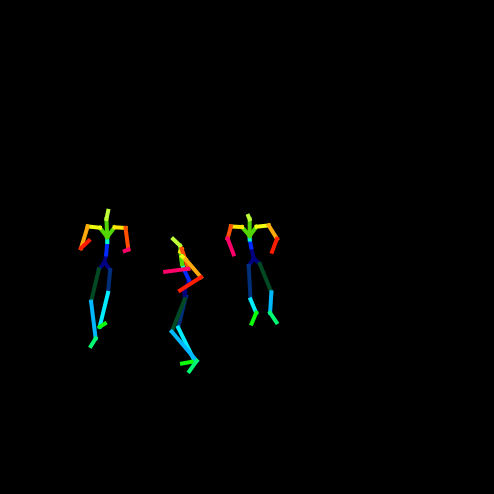

In [58]:
index = 20
img = plot_3d_motion(joints=data)

In [ ]:
img.shape

### working section 

In [ ]:
import os
import numpy as np

In [ ]:

directory_path = 'HumanML3D/new_joints'  # replace with your directory path

# List all files in the directory and its subdirectories
files = []
for root, dirs, filenames in os.walk(directory_path):
    for filename in filenames:
        files.append(os.path.join(root, filename))


print(files)


In [ ]:

directory_path = 'HumanML3D/new_joint_vecs'  # replace with your directory path

# List all files in the directory and its subdirectories
joints_vec = []
for root, dirs, filenames in os.walk(directory_path):
    for filename in filenames:
        joints_vec.append(os.path.join(root, filename))


print(joints_vec)


In [ ]:
data = np.load(files[0]) 
data.shape

In [ ]:
data_vec = np.load(joints_vec[0]) 
data_vec.shape

In [ ]:
print(data[0,0,0])
print(data[0,0,1])
print(data[0,0,2])

In [ ]:
print(np.min(data[:,:,0]))
print(np.min(data[:,:,1]))
print(np.min(data[:,:,2]))
print(np.max(data[:,:,0]))
print(np.max(data[:,:,1]))
print(np.max(data[:,:,2]))

In [ ]:
kinematic_chain = [[0, 2, 5, 8, 11], [0, 1, 4, 7, 10], [0, 3, 6, 9, 12, 15], [9, 14, 17, 19, 21], [9, 13, 16, 18, 20]]


In [ ]:

import numpy as np


import numpy as np
import cv2
import matplotlib.pyplot as plt
def map_full(data,frame_number):
    def project_points_with_camera(points_3d, camera_position, pitch, yaw, intrinsic_matrix, image_width, image_height):
        rvec = np.array([pitch, yaw, 0], dtype=np.float32)  # Roll is assumed to be 0
        rotation_matrix, _ = cv2.Rodrigues(rvec)

        projected_points, _ = cv2.projectPoints(points_3d, rvec, camera_position, intrinsic_matrix, None)

        projected_points = projected_points.reshape(-1, 2)
        projected_points[:, 0] = projected_points[:, 0].clip(0, image_width - 1)
        projected_points[:, 1] = projected_points[:, 1].clip(0, image_height - 1)

        return projected_points

    focal_length = 200
    image_width = 480
    image_height = 480
    intrinsic_matrix = np.array([ 
        [focal_length, 0, image_width/2], 
        [0, focal_length, image_height/2], 
        [0, 0, 1] 
    ])


    # fix = np.array([0, -3, 1], dtype=np.float32)
    camera_position = np.array([0, -2, 2], dtype=np.float32)

    target_point = np.array([-2, 1, 1], dtype=np.float32)
    fix = np.array([-2, 1, 1], dtype=np.float32)
    direction_vector = fix - camera_position

    # Calculate pitch (angle between direction vector and XY-plane)
    pitch = np.arctan2(-direction_vector[2], np.sqrt(direction_vector[0]**2 + direction_vector[1]**2))  # In radians

    # Calculate yaw (angle between projection of direction vector onto XY-plane and X-axis)
    yaw = np.arctan2(direction_vector[1], direction_vector[0])  # In radians



    print(f"Pitch: {np.rad2deg(pitch):.2f} degrees")
    print(f"Yaw: {np.rad2deg(yaw):.2f} degrees")

    projected_points = project_points_with_camera(
        data[frame_number], camera_position, pitch-0.5, yaw-1.6, intrinsic_matrix, image_width, image_height
    )

    print(projected_points.shape)


    fig, ax = plt.subplots()
    data2 = projected_points

    for index in range(len(data2)):

        ax.clear()
        # ... other plot settings ...

        for i, (chain, color) in enumerate(zip(kinematic_chain, colors)):
            if i < 5:
                linewidth = 4.0
            else:
                linewidth = 2.0

            # Plot only X and Y coordinates from original 3D data
            ax.plot(data2[chain, 0], data2[ chain, 1], linewidth=linewidth, color=color)

            # Plot each joint as a point (optional)
            ax.scatter(data2[ chain, 0], data2[chain, 1], marker='o', color='black') 

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')


    # Save the plot as an image (replace 'plot.png' with your desired filename)
    



    ax.set_xlim([0, 480])
    ax.set_ylim([0, 480])
    ax.set_aspect('equal')
    
    fig.savefig('plot.png', bbox_inches='tight', pad_inches=0)
    
    # plt.axis('off')
    # ax.set_xticklabels()
    # ax.set_yticklabels()
    # ax.set_zticklabels([])
    plt.show()

data = np.load(files[9]) 
map_full(data,0)


In [ ]:
data = np.load(files[3]) 
map_full(data,179)